In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import multiprocessing as mp
import time
import itertools

import argparse

DATASET_INFO = {'norway': [10, False], 'phil': [3, True], 'holland': [1.524, True], 'la': [28.34, False]}

# Load DEM data from file, 
# outputs elevations in meters

def load_dem_data_(filename,imperial=False):
    f = open(filename)

    lines = f.readlines()
    arr = []
    print("Elevation given in imperial units:", imperial)
    c = 1
    if imperial:
        c = 3.28084
    for i in range(1, len(lines)):
        vals = lines[i].split()
        a = []
        for j in range(len(vals)):
            a.append(float(vals[j])/c)
        arr.append(a)
    arr = np.array(arr)
    print("loaded DEM array with shape:", arr.shape)
    return arr

# Get DEM array xloc and yloc
# outputs all relevant values in km
def get_dem_xv_yv_(arr, resolution, visualize=True):
    sz = arr.shape[0]
    total_width = resolution * sz
    x = np.linspace(0, total_width, sz)
    y = np.linspace(0, total_width, sz)
    xv, yv = np.meshgrid(x, y)
    if visualize == True:
    #creates filled contour plot containing matrix of Z (where Z contains height values of x and y plane)
        plt.contourf(xv/1000, yv/1000, arr/1000)
        print("minimal elevation:", np.min(arr/1000), "maximum elevation:", np.max(arr/1000))
        plt.axis("scaled")
        plt.colorbar()
        plt.show()
    return xv, yv, arr
    #return xv/1000, yv/1000, arr/1000

    
# Construct grid
def get_array_neighbors_(x, y, left=0, right=500, radius=1):
    temp = [(x - radius, y), (x + radius, y), (x, y - radius), (x, y + radius)]
    neighbors = temp.copy()

    for val in temp:
        if val[0] < left or val[0] >= right:
            neighbors.remove(val)
        elif val[1] < left or val[1] >= right:
            neighbors.remove(val)

    return neighbors

# External use ok
def construct_nx_graph(xv, yv, elevation, triangles=True, p=2):
    
    n = elevation.shape[0]
    m = elevation.shape[1]
    print("shape", n, m)
    counts = np.reshape(np.arange(0, n*m), (n, m))
    G = nx.Graph()

    node_features = []
    #fig = plt.figure()
    #ax = fig.add_subplot(projection='3d')
    for i in trange(0, n):
        for j in range(0, m):
            idx1 = counts[i, j]
            G.add_node(idx1)
            node_features.append(np.array([xv[i, j], yv[i, j], elevation[i, j]]))
            neighbors = get_array_neighbors_(i, j, right=elevation.shape[0], radius=1)
            for neighbor in neighbors:
                p1 = np.array([xv[i, j], yv[i, j], elevation[i, j]])
                p2 = np.array([xv[neighbor[0], neighbor[1]], yv[neighbor[0], neighbor[1]], elevation[neighbor[0], neighbor[1]]])
                w = np.linalg.norm(p1 - p2, ord=p)
                #ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='black')
                idx2 = counts[neighbor[0], neighbor[1]]
                G.add_edge(idx1, idx2, weight=w)
    print("Size of graph:", len(node_features))
    if triangles:
        for i in trange(0, n - 1):
            for j in range(0, m - 1):
                # index cell by top left coordinate
                triangle_edge = [(counts[i, j], counts[i + 1, j + 1]), (counts[i + 1, j], counts[i, j + 1])]
                edge = triangle_edge[np.random.choice(2)]
                p1 = node_features[edge[0]]
                p2 = node_features[edge[1]]
                w = np.linalg.norm(p1 - p2, ord = p)
                #ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='black')
                G.add_edge(edge[0], edge[1], weight=w)
                
    #fig.savefig('../images/norway-250.png')
    return G, node_features


In [12]:
elevations=load_dem_data_("Downloads/norway-smallest.txt")

Elevation given in imperial units: False
loaded DEM array with shape: (2000, 2000)


minimal elevation: 0.8997 maximum elevation: 2.3165


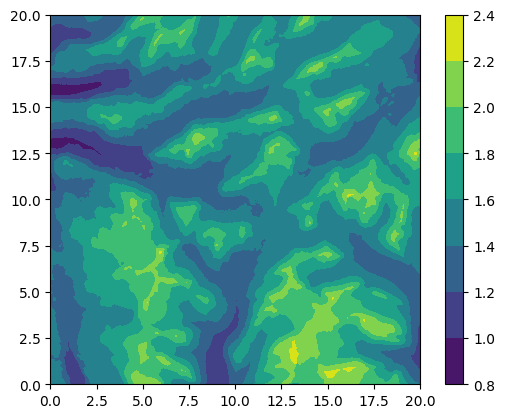

In [13]:
xv,yv,arr=get_dem_xv_yv_(elevations, 10)

In [14]:
G, node_features=construct_nx_graph(xv[:4,:4],yv[:4,:4],arr[:4,:4],triangles=True, p=2)

shape 4 4


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4576.44it/s]


Size of graph: 16


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1459.06it/s]


In [15]:
n= elevations[:4,:4].shape[0]
m= elevations[:4,:4].shape[1]

#.arange(start,stop,step) starting at 0 and going until n*m(-1) n*m to cover the amount of numbers added (4 rows, and 3 cols) 12 total
counts=np.reshape(np.arange(0,n*m),(n,m))
#reshapes arange into 2D
file= open("facestest.txt",'w')
#file.write("Faces")

for row in range(n-1):
    for col in range(m-1):
        #getting 2by2 grid 
        grid= counts[row:row+2,col:col+2]
    
        #topleft to bottom right on 2by2 grid
        diagonal_left_right= (grid[0,0].item(),grid[1,1].item())
        #top right to bottom left on 2by2 grid
        diagonal_right_left= (grid[0,1].item(),grid[1,0].item())
        #checking to see if an edge exists between the topleft and bottom right 
        edge_test= G.has_edge(*diagonal_left_right)
        #checking to see if an edge exists between the topright and bottom left
        edge_test2= G.has_edge(*diagonal_right_left)
        if edge_test==True:
            #get two triangles in the 2by2 grid
            faces1=(grid[0,0].item(),grid[0,1].item(),grid[1,1].item())
            faces2=(grid[0,0].item(),grid[1,0].item(),grid[1,1].item())

        elif edge_test2==True:
            #get two triangles in the 2by2 grid
            faces1=(grid[0,1].item(),grid[0,0].item(),grid[1,0].item())
            faces2=(grid[0,1].item(),grid[1,1].item(),grid[1,0].item())
        file.write(f'{faces1[0]} {faces1[1]} {faces1[2]}\n')
        file.write(f'{faces2[0]} {faces2[1]} {faces2[2]}\n')

file.close()

In [16]:
file = open("edgestest.txt",'w')

for e in tqdm(G.edges(data=True)):
    p1=node_features[e[0]]
    p2=node_features[e[1]]
    file.write(f'{e[0].item()} {e[1].item()}\n')


file.close()



100%|███████████████████████████████████████| 33/33 [00:00<00:00, 516462.81it/s]


In [17]:
#cell 6
numrow = len(xv[:4,:4])
numcol = len(xv[:4,:4][0])

file = open("verticestest.txt",'w')

for row in range(numrow):
    for col in range(numcol):
        file.write(f'{xv[:4,:4][row,col]} {yv[:4,:4][row,col]} {arr[:4,:4][row,col]}\n')

file.close()

100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 4089.22it/s]


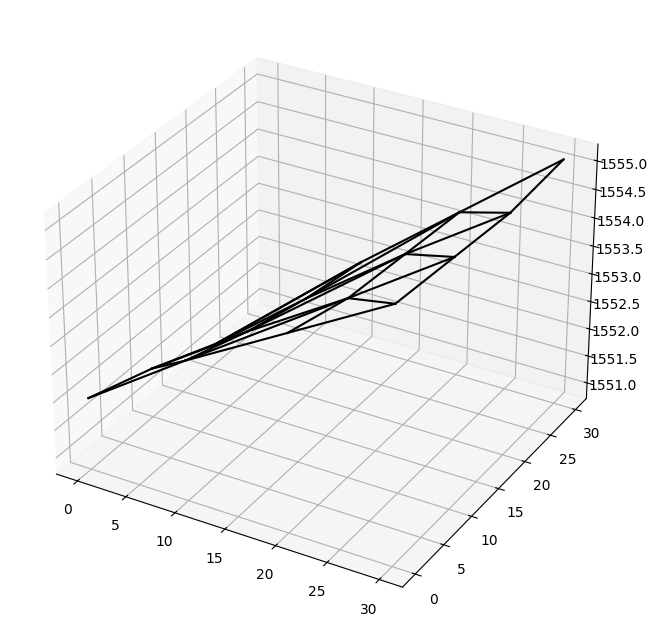

In [18]:
distances = []

edges = [[], []]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

for e in tqdm(G.edges(data=True)):
    p1 = node_features[e[0]]
    p2= node_features[e[1]]
            #x

    ax.plot([p1[0], p2[0]],
            #y
            [p1[1], p2[1]], 
            #z
            [p1[2], p2[2]], color='black')

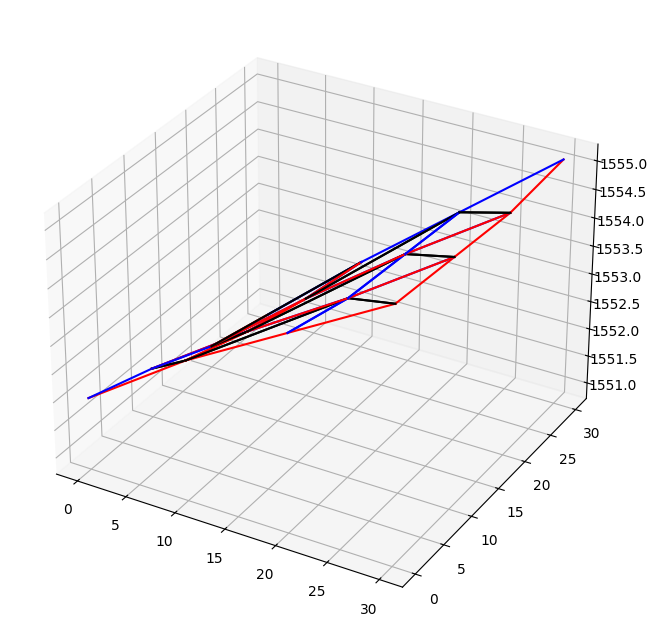

In [19]:
vertices= np.loadtxt('verticestest.txt')

#getting all the x values 
x = vertices[:,0]

#getting all the y values 
y= vertices[:,1]
#getting all the z values 
z= vertices[:,2]
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
'''
#checking to see if getting vertices worked 
ax= plt.axes(projection='3d')
ax.plot_wireframe(xv,yv,arr)
plt.show()
'''


#loading data from text file (integer values are in faces- set type to int)
faces = np.loadtxt("facestest.txt",dtype='int')
#for each line
for row in faces:
    #taking in three points (a,b,c) to represent vertices of triangle
    a,b,c=row
    #setting up the different points that will be plotted
    #want to get the x y and z value of that point and store them in a variable
    p1= (x[a],y[a],z[a])
    p2= (x[b],y[b],z[b])
    p3= (x[c],y[c],z[c])


    #plotting- 
    ax.plot([p1[0],p2[0]],
            [p1[1],p2[1]],
            [p1[2],p2[2]],color="red")
    ax.plot([p2[0],p3[0]],[p2[1],p3[1]],[p2[2],p3[2]],color="blue")
    ax.plot([p1[0],p3[0]],[p1[1],p3[1]],[p1[2],p3[2]],color="black")



plt.show()

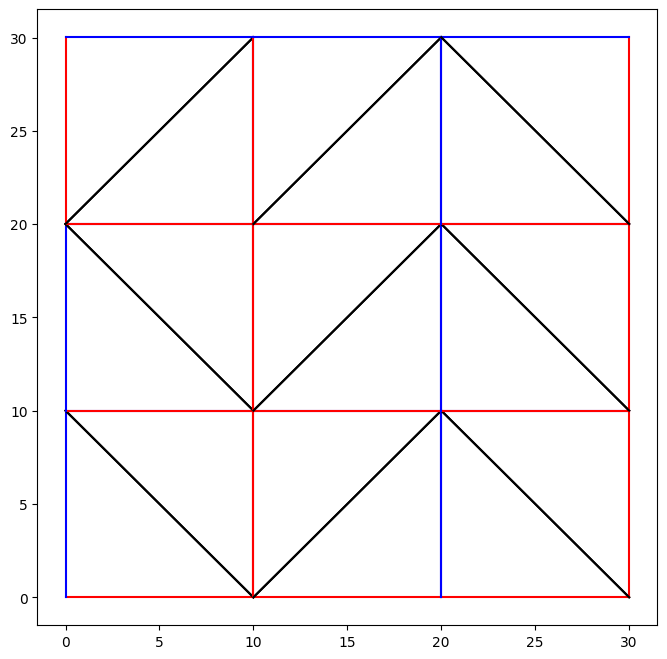

In [20]:
vertices= np.loadtxt('verticestest.txt')
#getting all the x values 
x = vertices[:,0]

#getting all the y values 
y= vertices[:,1]
#getting all the z values 
z= vertices[:,2]
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot()
'''
#checking to see if getting vertices worked 
ax= plt.axes(projection='3d')
ax.plot_wireframe(xv,yv,arr)
plt.show()
'''


#loading data from text file (integer values are in faces- set type to int)
#for each line
for row in faces:
    #taking in three points (a,b,c) to represent vertices of triangle
    a,b,c=row
    #setting up the different points that will be plotted
    #want to get the x y and z value of that point and store them in a variable
    p1= (x[a],y[a],z[a])
    p2= (x[b],y[b],z[b])
    p3= (x[c],y[c],z[c])


    #plotting- 
    ax.plot([p1[0],p2[0]],
            [p1[1],p2[1]],color="red")
    ax.plot([p2[0],p3[0]],[p2[1],p3[1]],color="blue")
    ax.plot([p1[0],p3[0]],[p1[1],p3[1]],color="black")



plt.show()  